<a href="https://colab.research.google.com/github/Limteckping45/COS30019Assignment2/blob/main/TransferLearningCJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import various libraries and modules
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
%cd /content
!git clone "https://github.com/Limteckping45/COS30019Assignment2"

/content
Cloning into 'COS30019Assignment2'...
remote: Enumerating objects: 3556, done.
remote: Counting objects: 100% (1162/1162), done.
remote: Compressing objects: 100% (1146/1146), done.
remote: Total 3556 (delta 30), reused 998 (delta 16), pack-reused 2394
Receiving objects: 100% (3556/3556), 403.57 MiB | 14.13 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (3256/3256), done.


In [6]:
# Directory paths for each dataset
training_dataset_dir = "/content/COS30019Assignment2/training_dataset"
testing_dataset_dir = "/content/COS30019Assignment2/testing_dataset"
validation_dataset_dir = "/content/COS30019Assignment2/validation_dataset"

In [7]:
# Define image dimensions
image_width, image_height = 224, 224
input_shape = (image_width, image_height, 3)

In [8]:
# Define batch size
batch_size = 32

In [9]:
# Set up data generators for training and testing
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_generator = train_datagen.flow_from_directory(
    training_dataset_dir,
    target_size = (image_width, image_height),
    batch_size = batch_size,
    class_mode = "categorical"
)

test_generator = test_datagen.flow_from_directory(
    testing_dataset_dir,
    target_size = (image_width, image_height),
    batch_size = batch_size,
    class_mode = "categorical"
)

Found 1920 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.


In [10]:
# Initialize MobileNetV2 without its top classification layers
base_model = MobileNetV2(
    weights = "imagenet",
    include_top = False,
    input_shape = input_shape
  )

9406464/9406464 [==============================] - 1s 0us/step


In [11]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(12, activation="softmax")(x)

In [12]:
# Construct a new model
model = Model(inputs = base_model.input, outputs = predictions)

In [13]:
# Freeze the layers of the base_model
for layer in base_model.layers:
  layer.trainable = False

In [14]:
# Compile the model in TensorFlow
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = "categorical_crossentropy",
    metrics=["accuracy"]
  )

In [15]:
# Start training process of the model
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    epochs = 15,
    validation_data = test_generator,
    validation_steps = test_generator.samples // batch_size
)

Epoch 1/15
60/60 [==============================] - 57s 843ms/step - loss: 1.4344 - accuracy: 0.6219 - val_loss: 0.8617 - val_accuracy: 0.8125
Epoch 2/15
60/60 [==============================] - 45s 748ms/step - loss: 0.4754 - accuracy: 0.9005 - val_loss: 0.5321 - val_accuracy: 0.8632
Epoch 3/15
60/60 [==============================] - 50s 832ms/step - loss: 0.2848 - accuracy: 0.9359 - val_loss: 0.4388 - val_accuracy: 0.8682
Epoch 4/15
60/60 [==============================] - 48s 798ms/step - loss: 0.2198 - accuracy: 0.9479 - val_loss: 0.3971 - val_accuracy: 0.8843
Epoch 5/15
60/60 [==============================] - 48s 799ms/step - loss: 0.1802 - accuracy: 0.9536 - val_loss: 0.3733 - val_accuracy: 0.8894
Epoch 6/15
60/60 [==============================] - 49s 826ms/step - loss: 0.1607 - accuracy: 0.9625 - val_loss: 0.3579 - val_accuracy: 0.8902
Epoch 7/15
60/60 [==============================] - 45s 749ms/step - loss: 0.1364 - accuracy: 0.9688 - val_loss: 0.3531 - val_accuracy: 0.8894

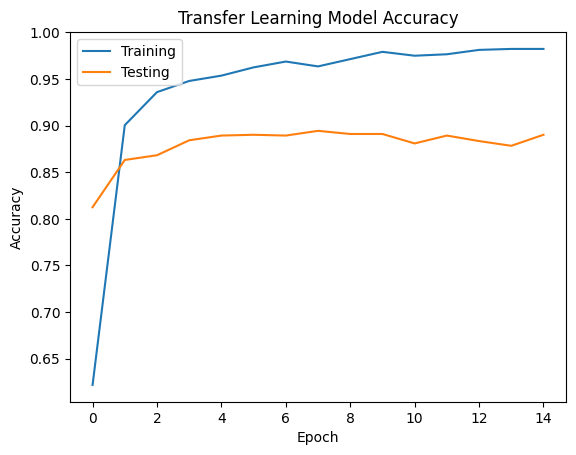

In [16]:
# Plot for training and testing accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Transfer Learning Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend (["Training", "Testing"], loc="upper left")
plt.show()

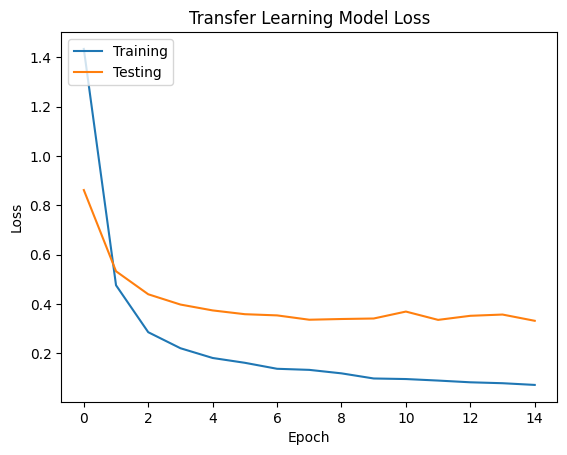

In [17]:
# Plot for training and testing loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Transfer Learning Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training", "Testing"], loc="upper left")
plt.show()

In [18]:
# Load and preprocess images for feeding into a neural network model
def load_image(image_path, target_size=(224, 224)):
  img = image.load_img(
      image_path,
      target_size = target_size
    )
  image_tensor = image.img_to_array(img)
  image_tensor = np.expand_dims(image_tensor, axis = 0)
  image_tensor /= 255.
  return image_tensor

In [19]:
# Generate a list of random image paths from a given directory
def get_random_images(data_directory, number_images = 10):
  testing_image_paths = []
  for curDir, subDirs, files in os.walk(data_directory):
    for file in files:
      if file.lower().endswith((".png", ".jpg", ".jpeg")):
        testing_image_paths.append(os.path.join(curDir, file))

  # Selecting images based on specified file extensions
  random_images = np.random.choice(testing_image_paths, number_images, replace = False)
  return random_images

In [38]:
# Function to display images with predicted breed
def display_images_with_breed(image_paths, predicted_breeds):
    fig, axs = plt.subplots(3, 4, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.5)

    for i, (image_path, predicted_breed) in enumerate(zip(image_paths, predicted_breeds)):
        row, col = divmod(i, 4)
        image = Image.open(image_path)
        image = image.resize((600, 600))
        axs[row, col].imshow(image)
        axs[row, col].axis("off")
        axs[row, col].set_title(f"Predicted Breed: {predicted_breed}")

    # Hide any empty subplots
    for j in range(i + 1, 12):
        row, col = divmod(j, 4)
        axs[row, col].axis("off")

    plt.show()

1/1 [==============================] - 0s 22ms/step


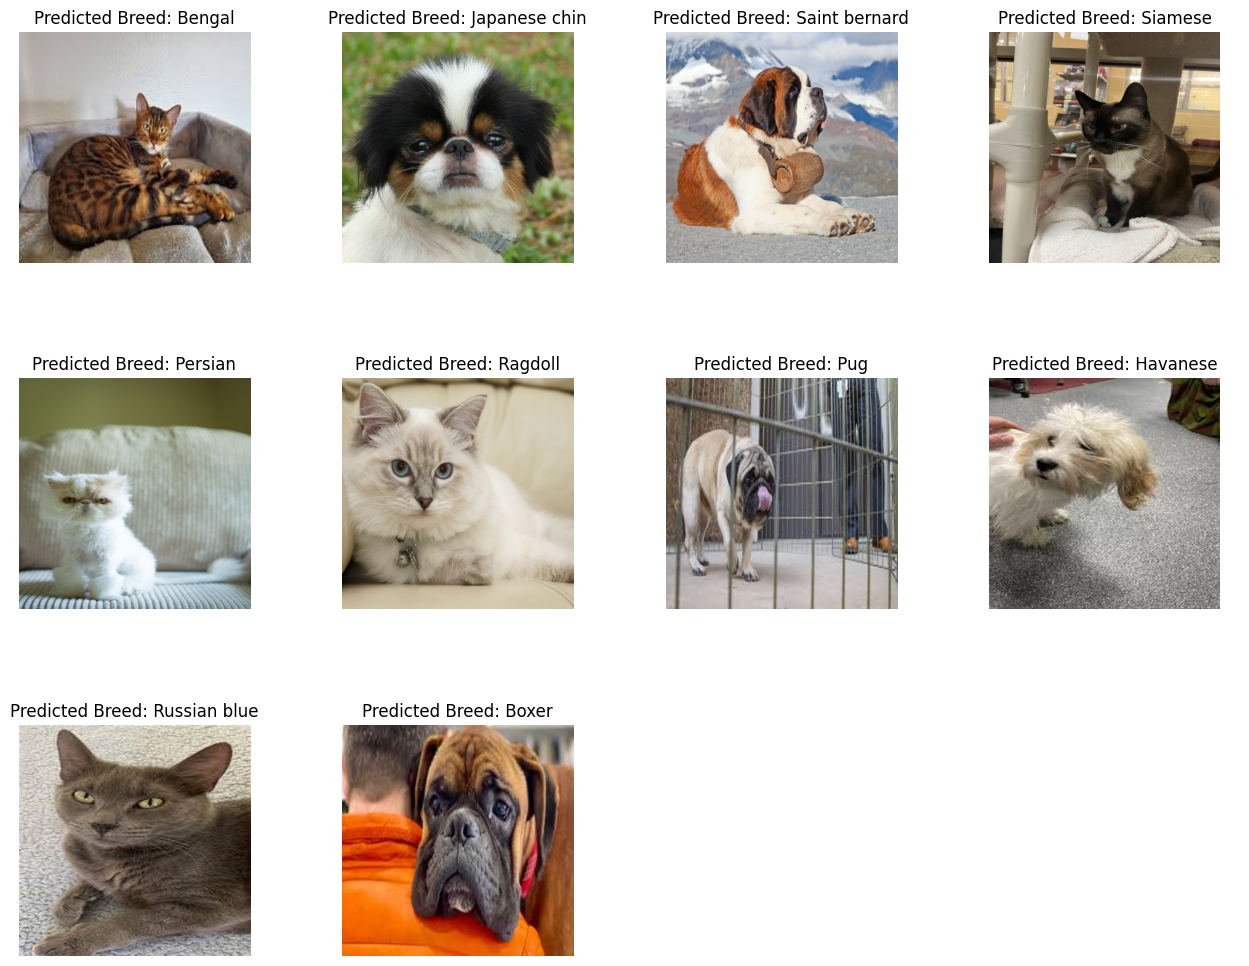

In [39]:
# Load random images from the validation dataset
random_images = get_random_images(validation_dataset_dir, number_images=10)
predicted_breeds = []

for image_path in random_images:
    new_image = load_image(image_path)

    # Predict the breed of each image using the trained model
    prediction = model.predict(new_image)
    breed = np.argmax(prediction, axis=1)

    # Determine the predicted breed name
    predicted_breed = list(train_generator.class_indices.keys())[breed[0]].replace("_", " ").capitalize()
    predicted_breeds.append(predicted_breed)

# Display the images with predicted breeds
display_images_with_breed(random_images, predicted_breeds)

In [ ]:
model.save("TransferLearning_Model.h5")